In [1]:
import paho.mqtt.client as mqtt
import threading
import os
import re
# import motionlocalizer.settings
import json
# import requests
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import xml.etree.ElementTree
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time as pythonTimer
import random
from random import randint
import scipy.stats as stats
from scipy.stats import multivariate_normal
import csv
import datetime
import pandas as pd

simworldname = 'simulationWorld2.xml' #ENVIROMENT
groundtruth = '28jun2.csv' #AGENT'S MOVEMENTS
motion_readings = '28Jun2_motion_events.txt'
# groundtruth = 'AgentDetailedTasksFile.csv' #AGENT'S MOVEMENTS

my_map = [(0.0, 0.0), (0.0, 10.6), (6.6, 10.6), (6.6, 0.0)]
grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
distances = []

oracle = {}
oracle['time'] = []
oracle['location'] = []

analyzer = {}
analyzer['time'] = []
analyzer['gridmap'] = []
 
def start_localizing(event):
    global analyzer
    global oracle
    global grid_map
    run_localization(event)

def run_localization(event):
    global analyzer
    global oracle
    global grid_map
    # print("run_localization")
    Localizer(pythonTimer.time()).run(event)


In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# sensor_readings = open(motion_readings, "r")
sensor_readings = open(motion_readings, "r").readlines()

dataset_times = []
dataset_readings = []
for i in range(0,len(sensor_readings)):
    time = sensor_readings[i].split(';')[0]
    sensor_array = sensor_readings[i].split(';')[1]
    dataset_times.append(int(time))
    dataset_readings.append(sensor_array)

dataset = ['time', 'gt(x)', 'gt(y)', 'motion_readings']
with open(groundtruth, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    for row in reader:
        new_row = []
        if (reader.line_num != 1):
            ind = find_nearest(dataset_times[1:], int(row[0]))
            dataset = np.vstack((dataset, [float(row[0]), float(row[4]), float(row[5]), dataset_readings[ind]]))
            

In [13]:
dataset

array([['time', 'gt(x)', 'gt(y)', 'motion_readings'],
       ['1498670641.0', '1.197742', '5.402001', '0000000000000000000000'],
       ['1498670642.0', '1.198065', '5.401716', '0000000000000000000000'],
       ...,
       ['1498677300.0', '3.4', '3.45', '0000000000000000000000'],
       ['1498677303.0', '3.4', '3.45', '0000000000000000000000'],
       ['1498677318.0', '3.4', '3.45', '0000000000000000010000']],
      dtype='<U32')

In [3]:
motions_order = [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9]
motion_sensors = [1, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9]
motions_sensor_data = {}

sr_matrix = np.zeros([1, 14])
for i in range(1,len(dataset)):
    sensor_array = dataset[i][3]
    sr_row = []
    for j in range(0,len(sensor_array)):
        if (motions_order[j] <= 14):
            sr_row.append(int(sensor_array[j]))

    sr_matrix = np.vstack((sr_matrix,sr_row))

i = 0
for sensor in motions_order:
    if (sensor <= 14):
        motions_sensor_data[sensor] = []
        motions_sensor_data[sensor] = sr_matrix[:, i]
        i = i + 1
        
for sensor in motion_sensors:
    new_readings = []
    new_readings.append(motions_sensor_data[sensor][0])
    for i in range(1, len(motions_sensor_data[sensor])):
        if (new_readings[len(new_readings) - 1] == motions_sensor_data[sensor][i]):
            new_readings.append(0)
        else:
            new_readings.append(1)

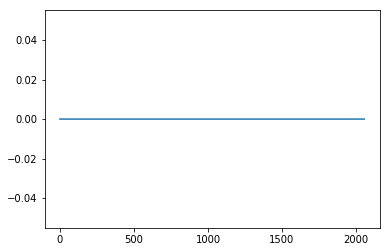

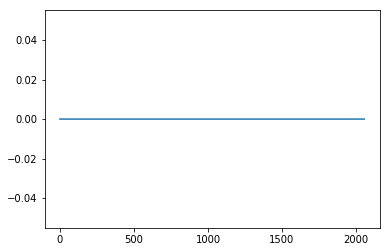

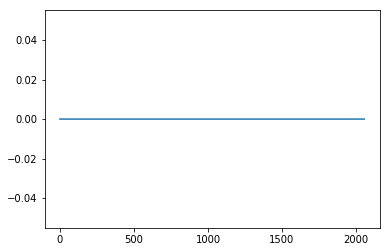

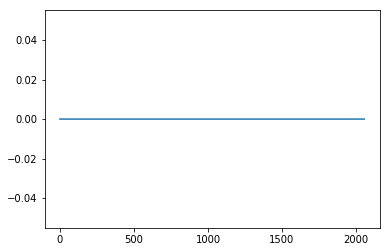

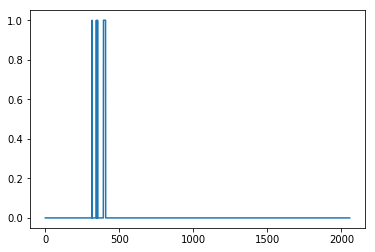

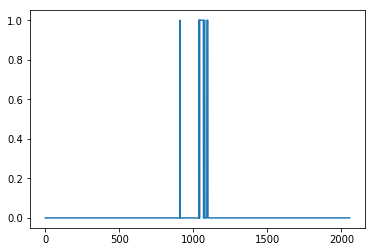

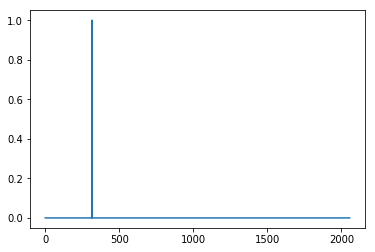

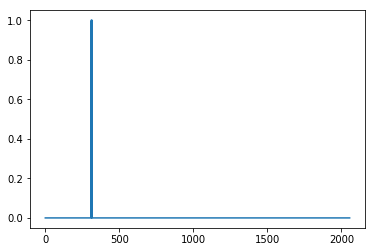

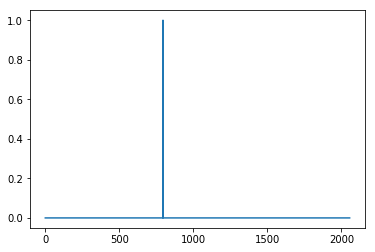

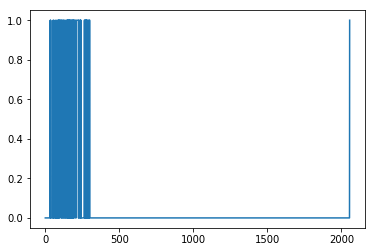

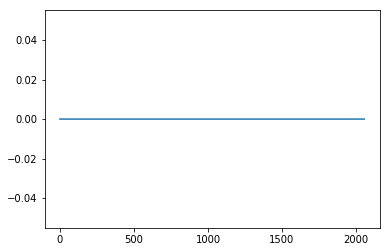

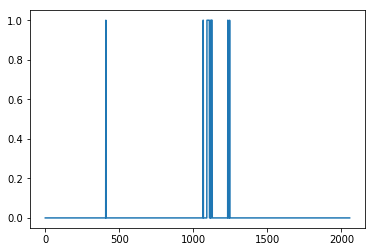

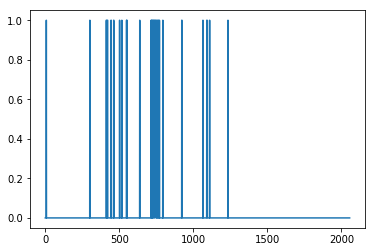

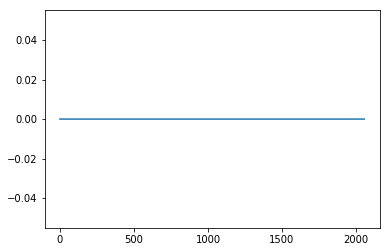

In [4]:
import matplotlib.pyplot as plt

for i in motion_sensors:
    plt.plot(list(range(0,len(motions_sensor_data[i]))), motions_sensor_data[i])
    plt.show()

In [5]:
##################################
####       Sensor Class       ####
##################################

class Sensor:
    sensor_type = ""
    sensor_id = ""
    x = float()
    y = float()
    z = float()

    def __str__(self):
        return 'type: %s,\n id: %s,\n x: %s,\n y: %s\n'%(self.sensor_type, self.sensor_id, self.x, self.y)

    def Initialize(self, element):
        self.x = (str(element.find('point').find('xcoord').text))
        self.y = (str(element.find('point').find('ycoord').text))
        self.sensor_id = (str(element.find('id').text))
        self.sensor_type = (str(element.find('type').text))     
            
        return 0
    
    
    '''
        This fucntion uses an 2D gaussian, that means: X~(x, mean, covarianceMatrix)
        Input:
        x = [xOracle, yOracle] (Actually we don't care about it anymore)
        mean = [xSimulator, ySimulator]
        covarianceMatrix= | r  0 | , where r is the circle radious
                          | 0  r |

        Returns: cdf of the normal distribution
        
    '''
    def GaussianFiredSensor(self, simulated_localization, real_localization):
        import math

        sensor_location = [float(self.x)/10, float(self.y)/10]
        cov = [[self.sensing_area, 0],[0, self.sensing_area]]        
        prob = multivariate_normal(simulated_localization, cov)
        probCdf = prob.cdf(sensor_location)
        
        print("real: ", real_localization)
        print("simu: ", simulated_localization)
              
        return probCdf
    
"""
System's sensors
All this classes are childrens from Sensor Class
"""
class MotionSensorBinary(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))

class RFID_Reader(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('arcSize').text))

class MotionSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        
class PressureSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.object = str(element.find('object').text)
        
class BeaconSensor(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.measuredPower = -69
        self.RSSI = self.sensing_area
        self.N = 2 #Constant related with the air
        self.object = str(element.find('object').text)
        self.accelerometer = str(element.find('accelerometer').text)
        
    # https://iotandelectronics.wordpress.com/2016/10/07/how-to-calculate-distance-from-the-rssi-value-of-the-ble-beacon/
    def rssiToMeters(self):
        u = (float(self.measuredPower) - float(self.RSSI))/(10 * float(self.N))
        dist = 10 ** u
        
        return dist
    
   # def distanceToMeasure(self, dist):
     #   mp = self.RSSI + (10*n*math.log10(dist)
    #    return mp
    

In [6]:
#Event Class
class Event:
    source = ""
    timestamp = float()
    RSSI = 0
    objectAtt = ""
    accelerometer = False
    sensor = Sensor.sensor_id
    sensorType = Sensor.sensor_type
    data = int()
    hash = ""

    def __str__(self):
        return 'time: %s --> sensor: <%s>, sensor type: %s data: %s' % (
        str(self.timestamp), str(self.sensor), str(self.sensorType), str(self.data))

In [7]:
class GridMap:
    map = ""

In [8]:
#Debug function, not working - just forget about it
def checkTypeSensor(sensor):
    if(sensor.sensor_type == 'RFID_Reader'):
        this_sensor = RFID_Reader(sensor) 
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorBinary'):
        this_sensor = MotionSensorBinary(sensor)
        #this_sensor = sensor
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorAnalog'):
        this_sensor = MotionSensorAnalog(sensor)
        return this_sensor

    if(sensor.sensor_type == 'PressureSensorAnalog'):
        this_sensor = PressureSensorAnalog(sensor)
        return this_sensor
    
    return "none"

In [9]:
############################################
####       PARSE SIMULATION WORLD       ####
############################################

root = xml.etree.ElementTree.parse(simworldname).getroot()

grid2 = np.zeros((int(my_map[2][0]) * 1, int(my_map[2][1]) * 1))
grid2 = np.copy(grid_map)

# print(grid2)

sensors_list = []

for element in root:
    if(element.tag == 'sensors'):
        for sensor in element:
            #Choose the kind of sensor we have
            if(str(sensor.find('type').text) == 'RFID_Reader'):
                this_sensor = RFID_Reader(sensor)
                
            if(str(sensor.find('type').text) == 'MotionSensorBinary'):
                this_sensor = MotionSensorBinary(sensor)
                
            if(str(sensor.find('type').text) == 'MotionSensorAnalog'):
                this_sensor = MotionSensorAnalog(sensor)
            
            if(str(sensor.find('type').text) == 'PressureSensorAnalog'):
                this_sensor = PressureSensorAnalog(sensor)
            
            if(str(sensor.find('type').text) == 'BeaconSensor'):
                this_sensor = BeaconSensor(sensor)
                
            sensors_list.append(this_sensor)
            # print(this_sensor.sensor_type + " " + this_sensor.x + " " + this_sensor.y)
            # sensors_list.append(sensor)
            # print(sensors_list[len(sensors_list) - 1])

In [10]:
############################################
####         LOCALIZATION CLASS         ####
############################################

class Localizer(threading.Thread):
    to_be_localized_queue = []
    localizer_lock = threading.Lock()
    this_grid_map = []
    
    
    def __init__(self, time):
        self.time = time

    def run(self, event):
        global grid_map
        global analyzer
        global oracle
        global distances
        # print("Run")
        Localizer.to_be_localized_queue.append(self.time)
        with Localizer.localizer_lock:
            while len(Localizer.to_be_localized_queue) > 0:
                timestamp = Localizer.to_be_localized_queue[0]
                Localizer.to_be_localized_queue = Localizer.to_be_localized_queue[1:]
                self.localize(timestamp, event)
    
    def localizer_confidence(self):
        return 0.9

    def get_event_period(self):
        return 1.0

    def getLocations(self, time, event):
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        grid2 = np.copy(grid_map)
        fired_sensors = self.FindFiredSensor(event, grid_map, event.timestamp)

        if len(fired_sensors) == 0:
            return
        
        counter = 0
        try:
            m1 = np.min(grid2[np.nonzero(grid2)])
            M1 = np.max(grid2[np.nonzero(grid2)])

            # print("Value in try:", m1)
            # print("Value in try:", M1)
            
        except:
            print("start!")
        
        for i in range(len(grid2[:,1])):
            for j in range(len(grid2[1,:])):
                for sensor in fired_sensors:
                    
                    #my_sensor = checkTypeSensor(sensor)
                    my_sensor = sensor
                    r = float(my_sensor.sensing_area)/10
                    x = float(my_sensor.x)/10
                    y = float(my_sensor.y)/10
                    
                    circ = Circle((int(int(x)), int(int(y))), int(int(r)))
                    
                    if (circ.contains_point([i, j])):
                        grid2[i][j] += 1
        
        sumofpoints = sum(sum(grid2))/4
        
        if (sumofpoints == 0):
            print("no 1")
        else:
            grid2 = np.true_divide(grid2, sumofpoints)
        
        inferred_location = self.AskLocationFromLocalizer(grid2)
        real_location2 = self.AskLocationFromOracle(time)
   
        return inferred_location, real_location2, fired_sensors
        
    def localize(self, time, event):
        global grid_map
        global analyzer
        global oracle
        global distances
        
        #finds the inferred an real locations, and what sensors were fired
        inferred_location, real_location, fired_sensors2 = self.getLocations(event.timestamp, event)    
        k = 0
        
        #Choose what sensor was REALLY deployed based on the probability
        i = len(fired_sensors2)
        
        if(i > 0):
            i -= 1
        
        while(i >= 0):         
            current_sensor = fired_sensors2[i]
            #get the probability from the gaussian filter
            probi = current_sensor.GaussianFiredSensor(inferred_location, real_location)
            
            if(probi < 0.015):
                del fired_sensors2[i]
            i -= 1
            #print(probi)
                
        fired_sensors = fired_sensors2
        
        if len(fired_sensors) == 0:
            return
        
        counter = 0
        
        try:
            m1 = np.min(grid_map[np.nonzero(grid_map)])
            M1 = np.max(grid_map[np.nonzero(grid_map)])
            
        except:
            print("start!")
        
        
        for i in range(len(grid_map[:,1])):
            for j in range(len(grid_map[1,:])):
                for sensor in fired_sensors:
                    #my_sensor = checkTypeSensor(sensor)
                    my_sensor = sensor
                    r = float(my_sensor.sensing_area)/10
                    x = float(my_sensor.x)/10
                    y = float(my_sensor.y)/10
                    #print("i: ", i, "j: ", j)
                    #print("x: ", x, "y: ", y, "r: ", r)
                    
                    circ = Circle((int(int(x)), int(int(y))), int(int(r)))
                    
                    if (circ.contains_point([i, j])):
                        grid_map[i][j] += 1
        
        sumofpoints = sum(sum(grid_map))/4
          
        if (sumofpoints == 0):
            print("no 2")
        else:
            grid_map = np.true_divide(grid_map, sumofpoints)
    
        dist = self.ReportError(event.timestamp, grid_map)
        distances.append(dist) 
        
        analyzer['time'].append(event.timestamp)
        analyzer['gridmap'].append(grid_map)

        # plt.imshow(zip(*grid_map), cmap='hot', interpolation='nearest')
        plt.imshow(grid_map, cmap='hot', interpolation='nearest')
        plt.show()
        print("\n")
    
    def ReportError(self, time, recent_grid):
        global oracle
        
        inferred_location = self.AskLocationFromLocalizer(recent_grid)
        real_location = self.AskLocationFromOracle(time)
        
        #print(inferred_location)
        #print(real_location)
        
        return np.linalg.norm(inferred_location - real_location)
        
        
    def AskLocationFromLocalizer(self, recent_grid):
        return np.mean(list(zip(*np.where(recent_grid == np.max(recent_grid)))), axis = 0)
    
    def AskLocationFromOracle(self, time):  
        point = np.mean(np.asarray(oracle['location'])[np.where(np.asarray(oracle['time']) == int(time))], axis = 0)
        #print("ponto: ", point, "time: ", time)
        return point
    
    """
    I'm implementing a randomic action fiture for the sensors, causing false-positive events. Basically, 
    to choose WHICH sensor will be deployed, I get an random number between [0 - (X - 1)], where X is the length 
    of the sensor list. To choose WHEN the sensor is deployed, I'll define a variable called "control = 123", and
    create a list of random 10 numbers between [0 - 150], everytime the list contains whe variable control, we
    switch to the random event.
    """
    def FindFiredSensor(self, event, grid_map, time):
        fired_sensors2 = []
        firedsensor = event.sensor
        
        listControl = random.sample(range(0, 150), 10)
        control = 123
        
        if(control in listControl):  
            rand = randint(0, len(sensors_list) - 1)
            current_sensor = sensors_list[rand]
            fired_sensors2.append(current_sensor)
        
        for i in range(len(sensors_list)):
            #print(sensors_list[i])
            current_sensor = sensors_list[i]

            if current_sensor.sensor_id == firedsensor:
                fired_sensors2.append(current_sensor)  
                
        return fired_sensors2


    def extract_fired_sensors(self, start, end):
        sensors = sensors_list
        fired_sensors = []
        for s in sensors:
            if Event.objects.filter(timestamp__gt=start, timestamp__lt=end, sensor=s).exists():
                fired_sensors.append(s)
                continue
            if Event.objects.filter(sensor=s).exists():
                last_event = Event.objects.filter(sensor=s).latest(field_name='timestamp')
                if int(last_event.data) == 1:
                    # print('latest is 1')
                    # print(s)
                    fired_sensors.append(s)

        return fired_sensors


In [11]:
#temporary:
# my_map = [(0.0, 0.0), (0.0, 5.7), (7.05, 5.7), (7.05, 0.0)]
# grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))



# print(np.max(grid_map))
# print("first input")
# result = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-288.3-495.0 1538687434000,MotionSensorBinary,MotionSensorBinary-288.3-495.0,TRUE,TRUE1"
# event = ParseResult(result)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()

# print('---------------------------')

# print(np.max(grid_map))
# print("second input")
# result1 = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-511.6-343.6 1538687449000,MotionSensorBinary,MotionSensorBinary-511.6-343.6,TRUE,TRUE1"
# event = ParseResult(result1)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()



In [12]:
#Debug function, sees what kind of activity we have
def typeAction(type):
    if(type == "Sleep"):
        print(type + "ENTREI")

    if(type == "walk"):
        print(type + "ENTREI")
        
    if(type == "Water"):
        print(type + "ENTREI")
        
    if(type == "Wash"):
        print(type + "ENTREI")
        
    if(type == "Entertainment"):
        print(type + "ENTREI")
        
    if(type == "Exercise"):
        print(type + "ENTREI")

    if(type == "Clean"):
        print(type + "ENTREI")
        
    if(type == "Eat"):
        print(type + "ENTREI")
        
    if(type == "Sit"):
        print(type + "ENTREI")

In [30]:
#I did what Shadan asked me, but I cannot test without the real file!
"""
Function to read the path in the csv file and turn it on an event.
The event is composed of: (sensor Id, data, hasg, source, time)
Everytime that a sensor finds
"""
def readFileCSV():       
    dataFile = []
    i = 0
    cont = 0
    cont2 = 0
    
    #Read all data from the csv file
    # with open(groundtruth, 'r') as csvFile:
    #     reader = csv.reader(csvFile)
    #     for line in reader:
    #         dataFile.append(line)
            
    # i = len(dataFile) - 1
    
    for i in range(1, len(dataset) + 1):
        xtrace = dataset[i][1]
        ytrace = dataset[i][2]
        x = abs(float(xtrace)) * 10
        y = abs(float(ytrace)) * 10
        loc = [x, y]
        timetoadd = int(round(float(dataset[i][0])))
        
        if loc not in oracle['location'] and timetoadd not in oracle['time']:
            oracle['location'].append(loc)
            oracle['time'].append(timetoadd) 

        
        event = Event()  
        
            
            
        
        
        for sensor in sensors_list:
            if(float(xtrace) * 10 >= (float(sensor.x) - float(sensor.sensing_area)) 
               and float(xtrace) * 10 <= (float(sensor.x) + float(sensor.sensing_area))):
                cont2 += 1
            else:
                cont += 1
            
            if(abs(float(ytrace)) * 10 >= (float(sensor.y) - float(sensor.sensing_area))
            and abs(float(ytrace)) * 10 <= (float(sensor.y) + float(sensor.sensing_area))):
                cont2 += 1
            else:
                cont += 1
            

            
            #If it's inside the sensor area, create an event and send it to the localizer

            if(cont2 != 0):
                event = Event()
                
                # Beacon Sensors
                if(sensor.sensor_type == "BeaconSensor"):
                    event.RSSI = sensor.RSSI #RSSI, just for beacons
                    event.accelerometer = sensor.accelerometer #if it's moving or not - jsut for beacon
                    event.objectAtt = sensor.object #Object where the sensor is
                    
                # Pressure Sensors
                elif(sensor.sensor_type == "PressureSensorAnalog"):
                    event.objectAtt = sensor.object #Object where the sensor is
                    
                else:               
                    event.RSSI = 0 #RSSI, just for beacons
                    event.objectAtt = "" #Object where the sensor is
                    event.accelerometer = False #if it's moving or not - jsut for beacon
                           
                event.sensor = sensor.sensor_id #SensorId that created the event
                event.data = "TRUE"  #data
                event.hash = "|hash|" #hash
                event.source = "xmlFile" #where is coming from
                event.timestamp = int(round(float(dataset[i][0]))) #timestamp
                event.sensorType = sensor.sensor_type #type of sensor
                
                print(event)
                
                run_localization(event)
            
            cont = 0
            cont2 = 0
        i -= 1

time: 1498670641 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [11.97742 54.02001]
simu:  [ 9.         22.05357143]
real:  [11.97742 54.02001]
simu:  [ 9.         22.05357143]


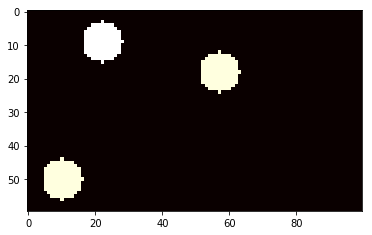



time: 1498670642 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [11.98065 54.01716]
simu:  [50.         10.05357143]


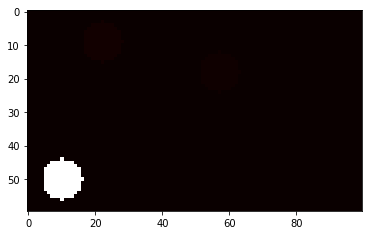



time: 1498670643 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [11.98387 54.0143 ]
simu:  [50.         10.05357143]


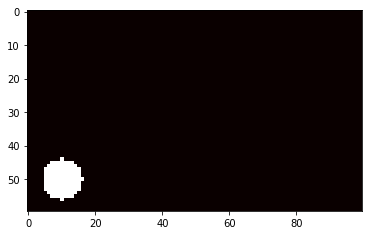



time: 1498670644 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [11.9871  54.01144]
simu:  [50.         10.05357143]


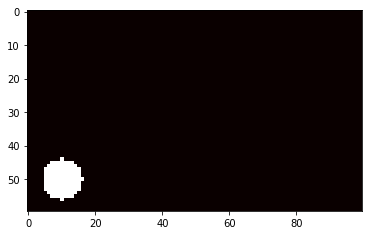



time: 1498670645 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [11.99032 54.00858]
simu:  [50.         10.05357143]


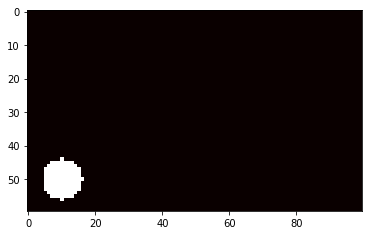



time: 1498670646 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [11.99355 54.00572]
simu:  [50.         10.05357143]


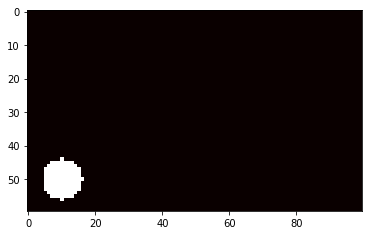



time: 1498670688 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [12. 54.]
simu:  [50.         10.05357143]


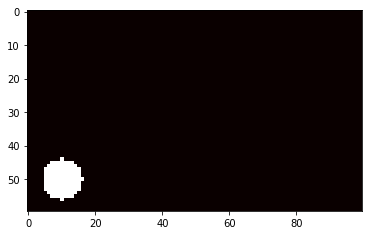



time: 1498670691 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


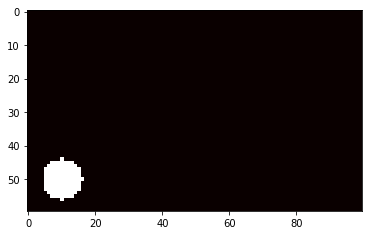



time: 1498670694 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


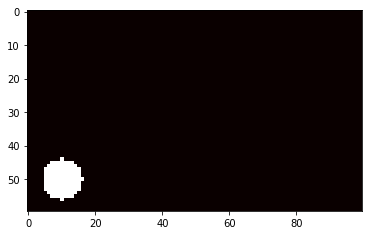



time: 1498670697 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


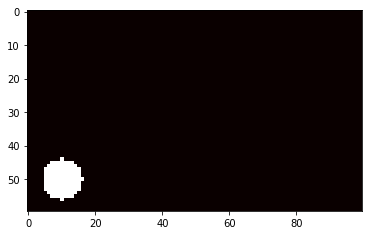



time: 1498670700 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


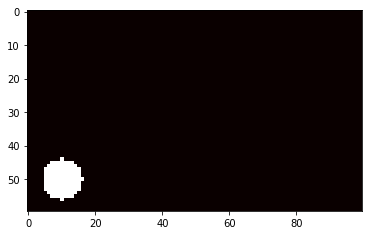



time: 1498670703 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


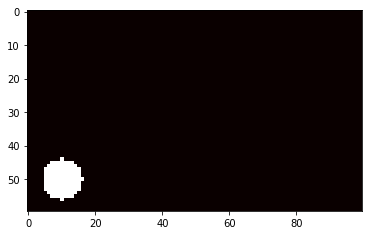



time: 1498670706 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


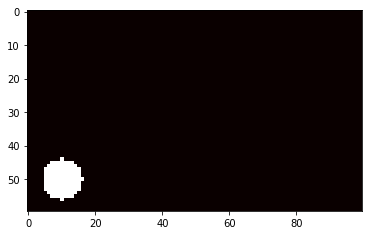



time: 1498670709 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


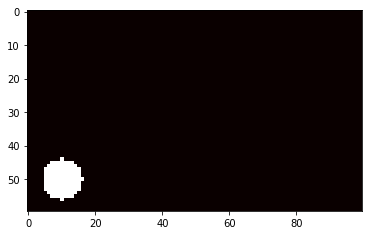



time: 1498670712 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


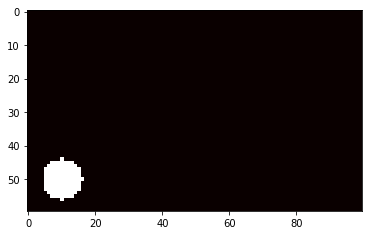



time: 1498670715 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


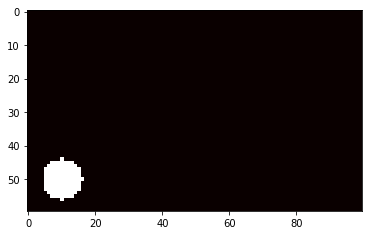



time: 1498670718 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


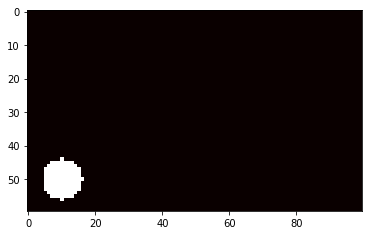



time: 1498670721 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [15.66667 50.5    ]
simu:  [50.         10.05357143]


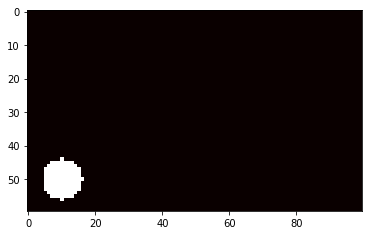



time: 1498670727 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [34. 33.]
simu:  [ 9.         22.05357143]


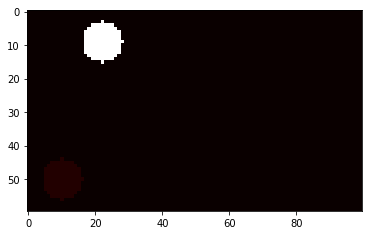



time: 1498670730 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


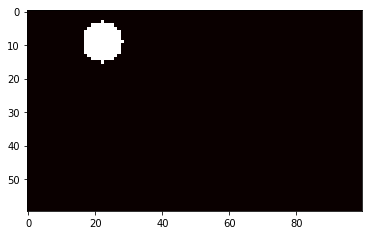



time: 1498670733 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


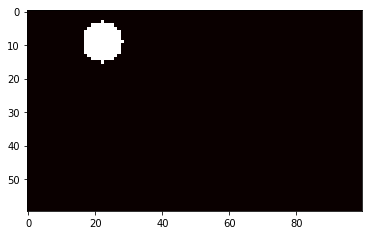



time: 1498670736 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


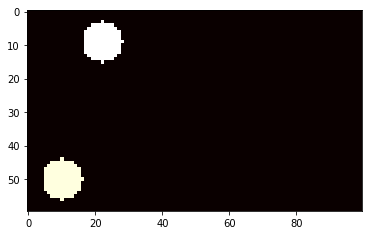



time: 1498670739 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


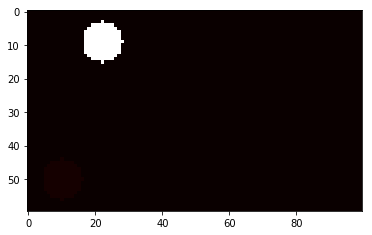



time: 1498670742 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


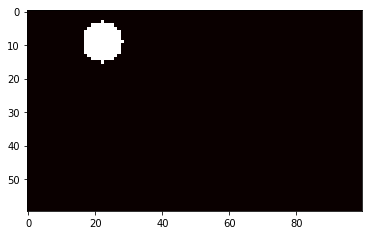



time: 1498670745 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


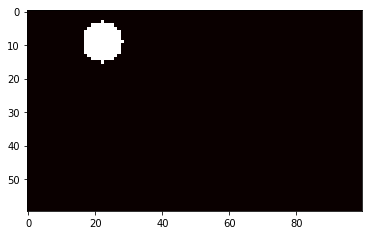



time: 1498670748 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


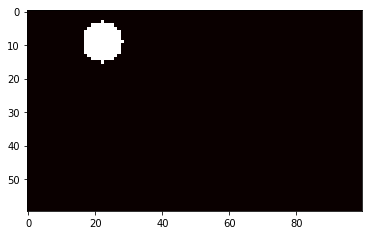



time: 1498670751 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


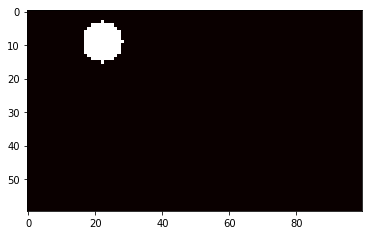



time: 1498670754 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


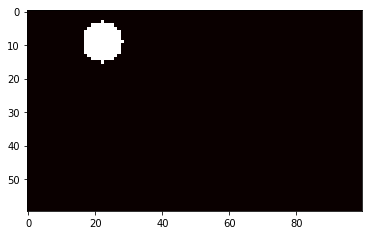



time: 1498670757 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


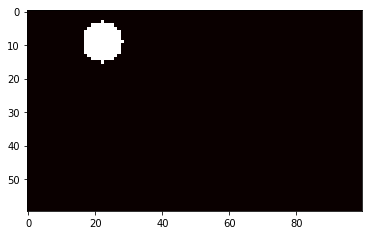



time: 1498670760 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


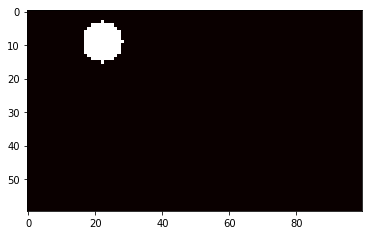



time: 1498670763 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


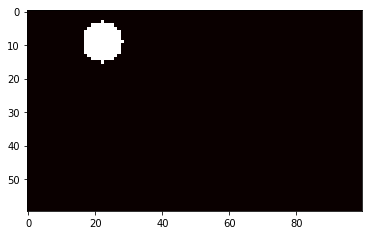



time: 1498670766 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


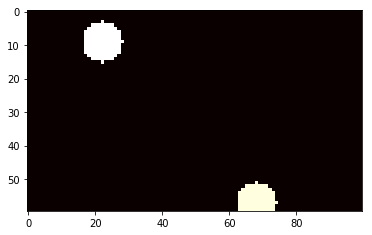



time: 1498670802 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


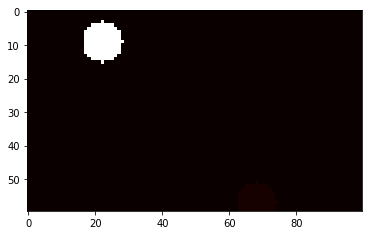



time: 1498670805 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


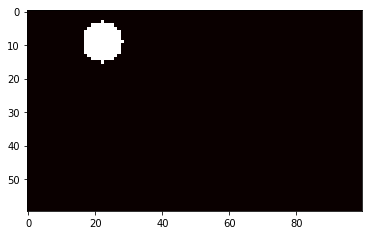



time: 1498670811 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


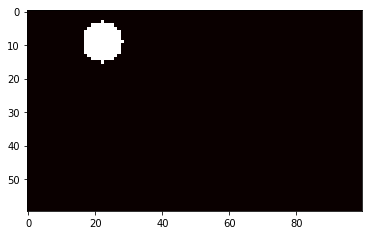



time: 1498670814 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


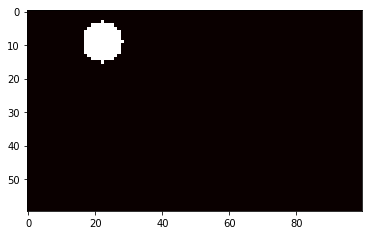



time: 1498670817 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


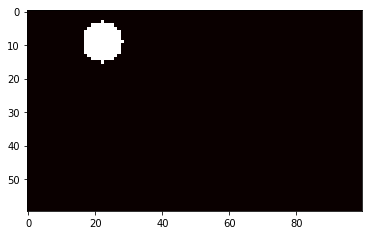



time: 1498670820 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


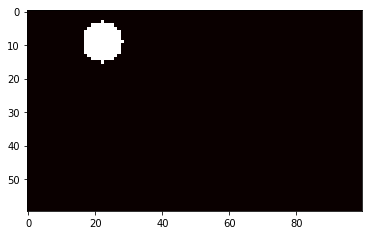



time: 1498670822 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


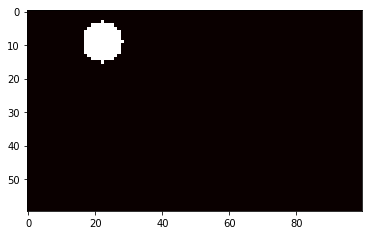



time: 1498670823 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


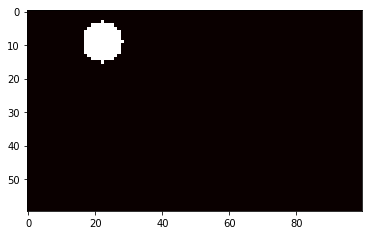



time: 1498670824 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


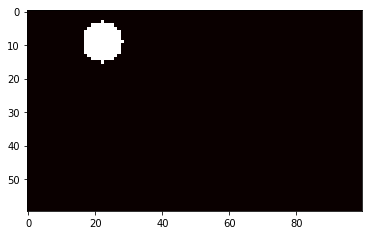



time: 1498670825 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


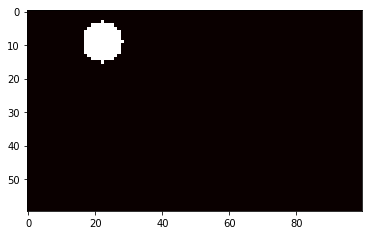



time: 1498670826 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


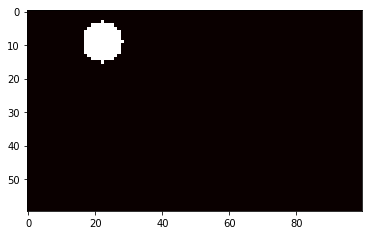



time: 1498670827 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


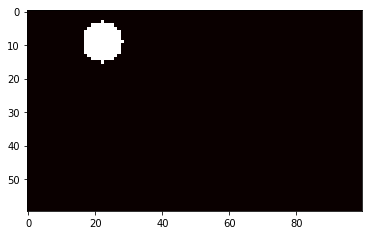



time: 1498670828 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


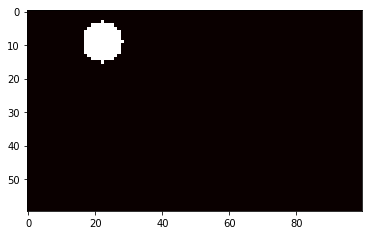



time: 1498670829 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


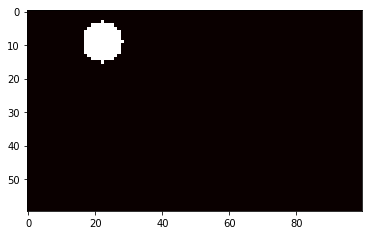



time: 1498670832 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


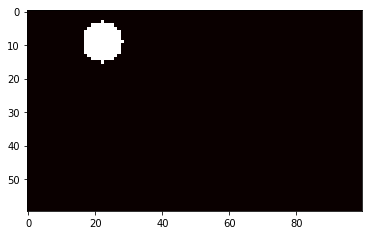



time: 1498670835 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


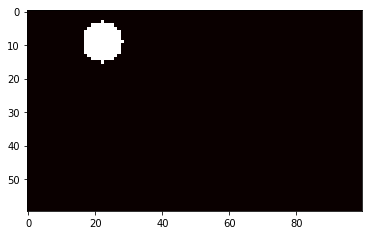



time: 1498670837 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


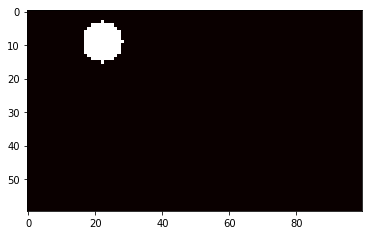



time: 1498670838 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


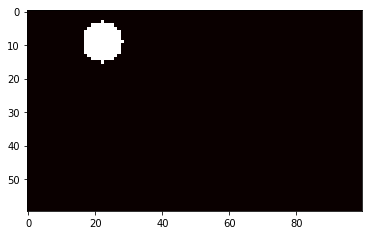



time: 1498670839 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


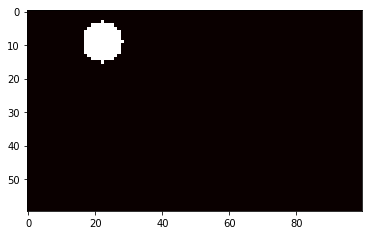



time: 1498670856 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


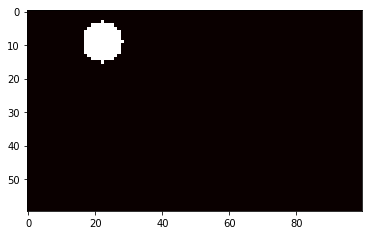



time: 1498670859 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


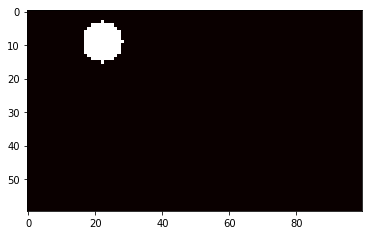



time: 1498670862 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


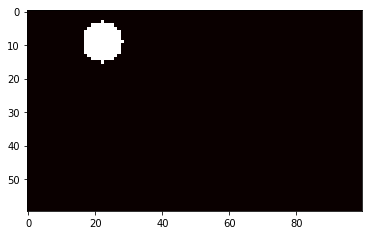



time: 1498670865 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


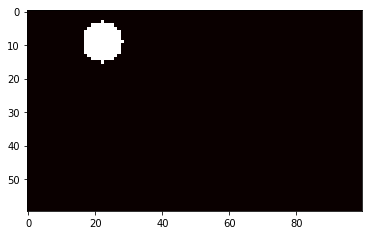



time: 1498670871 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


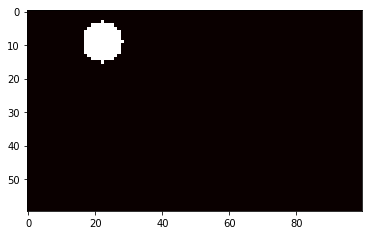



time: 1498670874 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


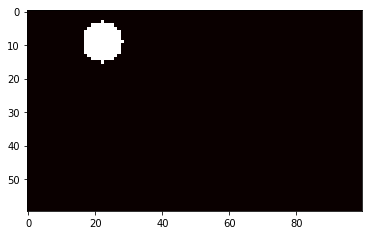



time: 1498670877 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


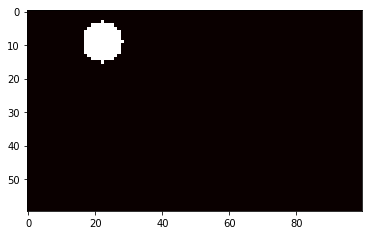



time: 1498670879 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


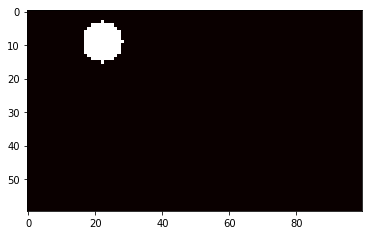



time: 1498670880 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


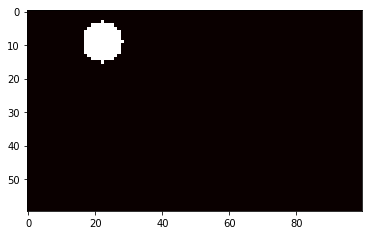



time: 1498670883 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


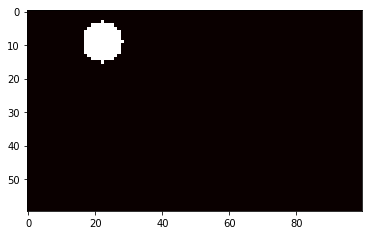



time: 1498670886 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


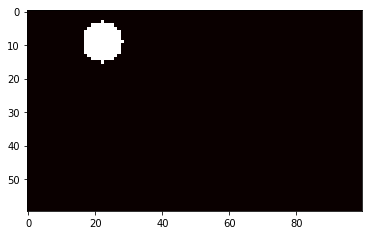



time: 1498670889 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


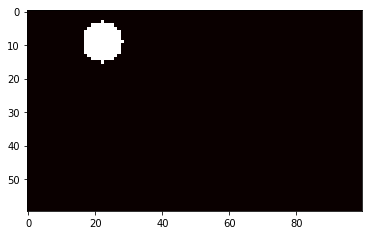



time: 1498670892 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


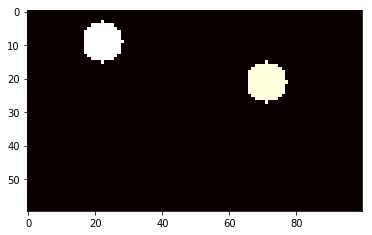



time: 1498670895 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


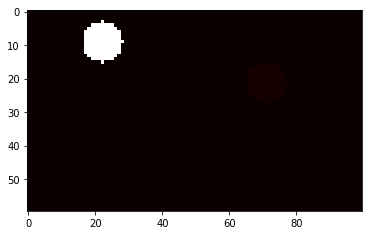



time: 1498670898 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


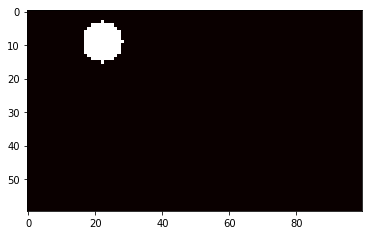



time: 1498670904 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


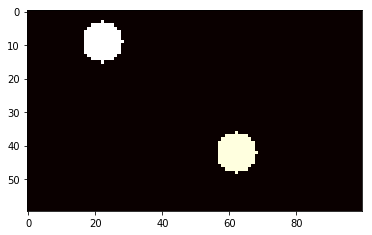



time: 1498670907 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


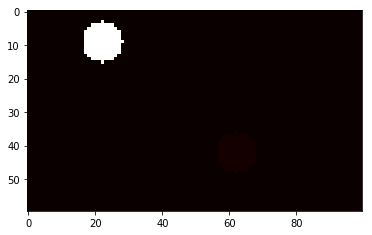



time: 1498670910 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


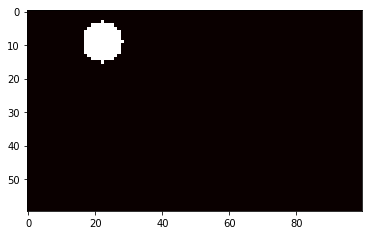



time: 1498670913 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


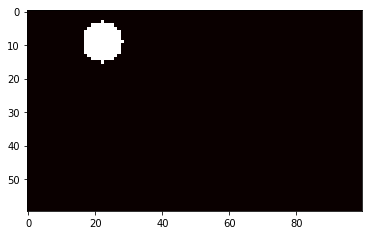



time: 1498670916 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


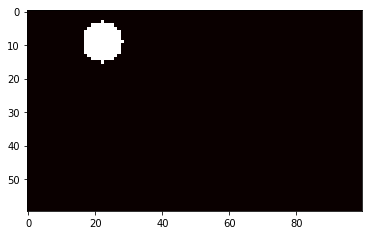



time: 1498670919 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


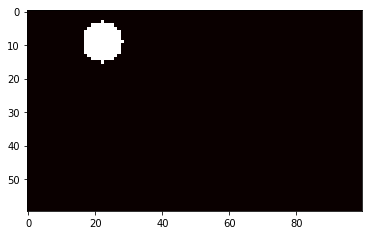



time: 1498670922 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


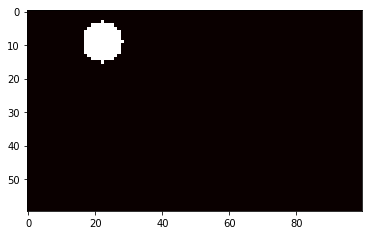



time: 1498670925 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


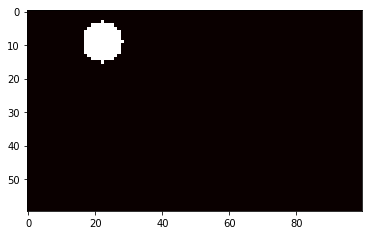



time: 1498670928 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


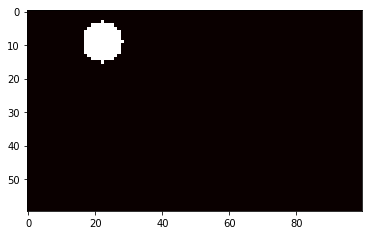



time: 1498670937 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


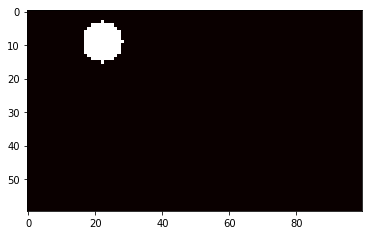



time: 1498670940 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


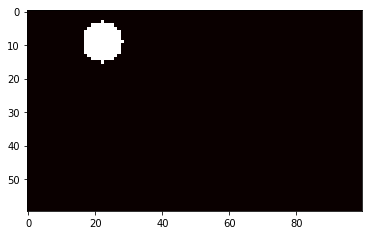



time: 1498670943 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


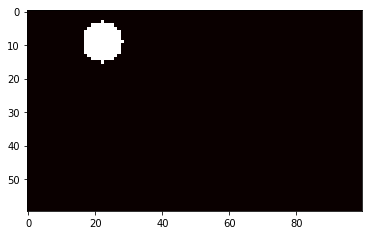



time: 1498670946 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


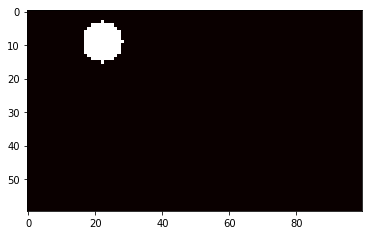



time: 1498670949 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


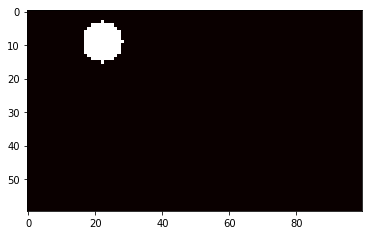



time: 1498670952 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


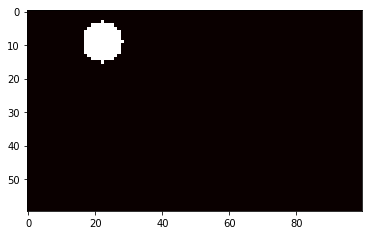



time: 1498670955 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


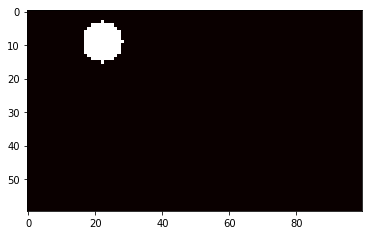



time: 1498670976 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


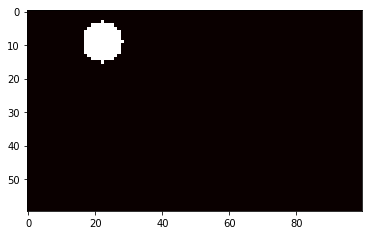



time: 1498670979 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


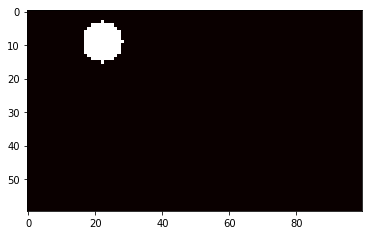



time: 1498670982 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


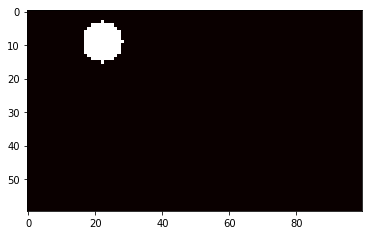



time: 1498670985 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


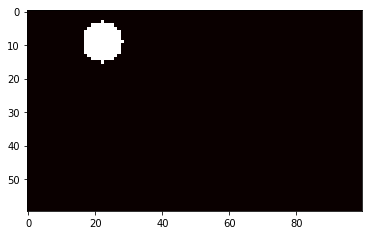



time: 1498670988 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


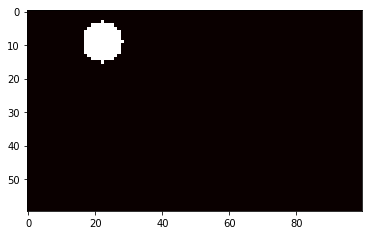



time: 1498670997 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


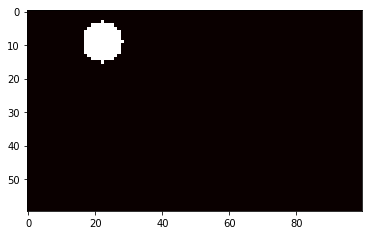



time: 1498671000 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


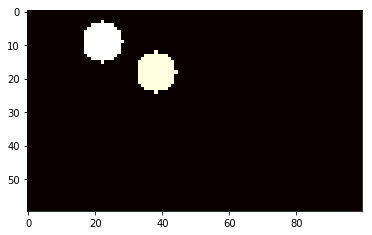



time: 1498671006 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


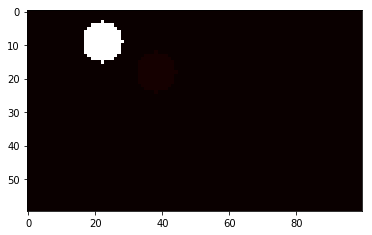



time: 1498671009 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


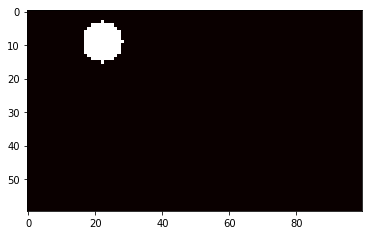



time: 1498671013 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


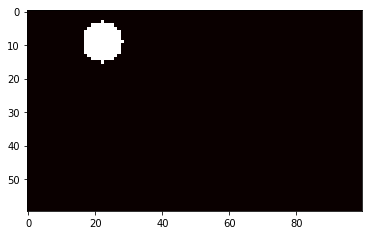



time: 1498671014 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


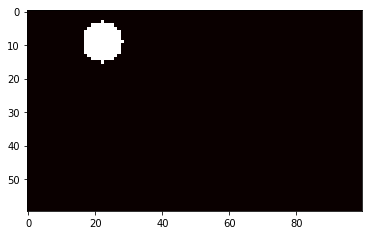



time: 1498671015 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


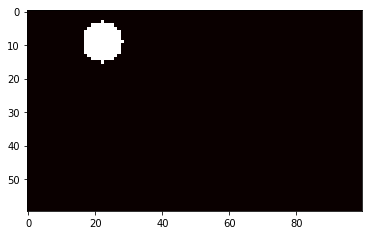



time: 1498671016 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


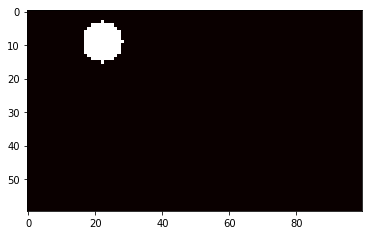



time: 1498671030 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


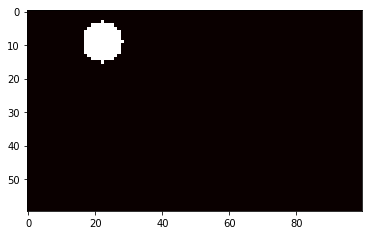



time: 1498671033 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


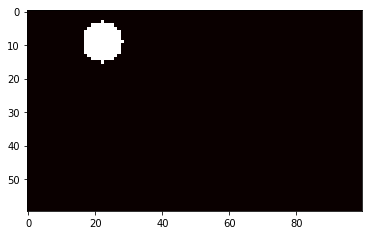



time: 1498671039 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


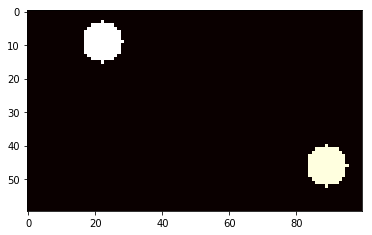



time: 1498671045 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


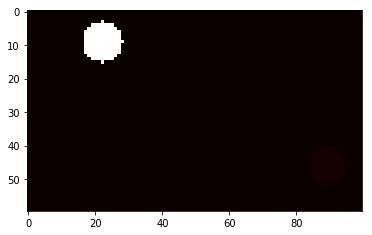



time: 1498671046 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


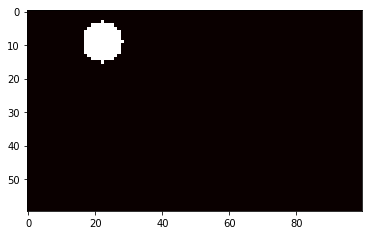



time: 1498671047 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


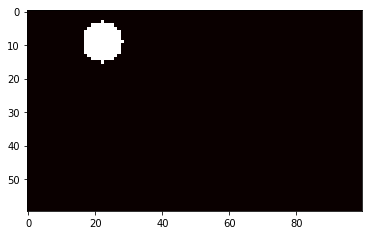



time: 1498671048 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


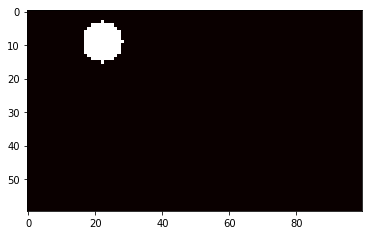



time: 1498671049 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


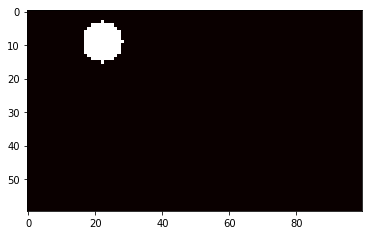



time: 1498671057 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


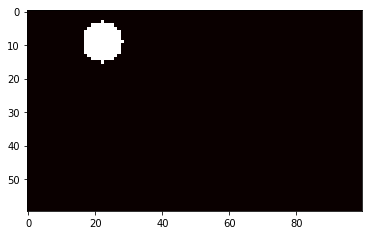



time: 1498671075 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


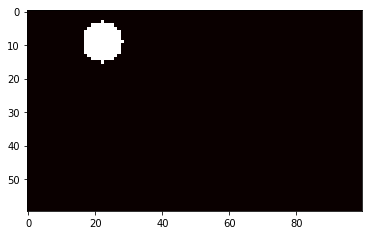



time: 1498671078 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


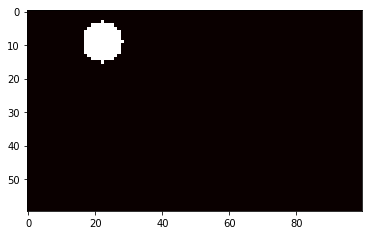



time: 1498671084 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


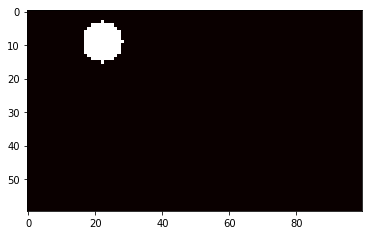



time: 1498671090 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


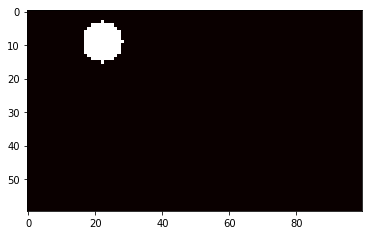



time: 1498671091 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


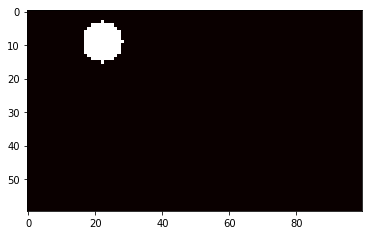



time: 1498671092 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


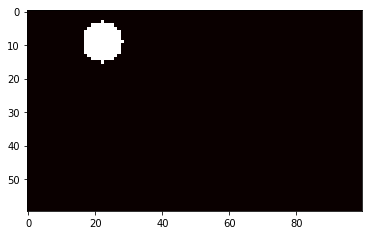



time: 1498671093 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


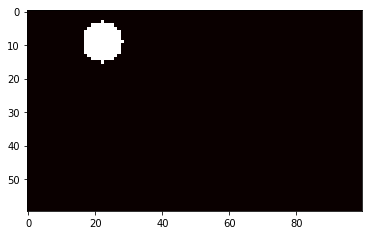



time: 1498671094 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


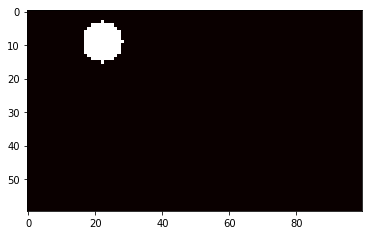



time: 1498671095 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


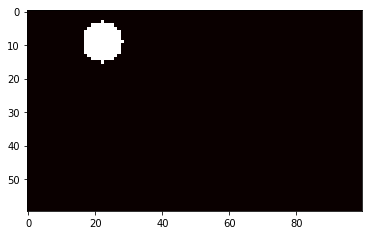



time: 1498671096 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


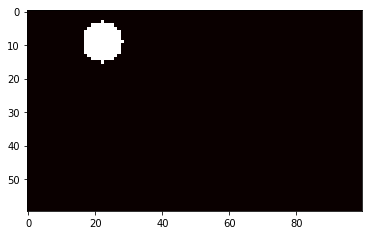



time: 1498671117 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


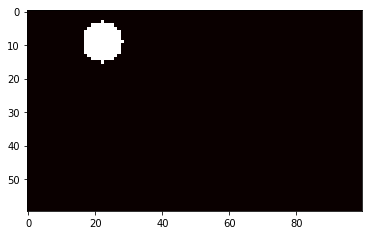



time: 1498671126 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


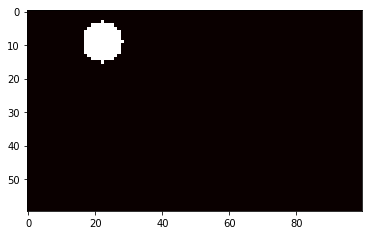



time: 1498671135 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


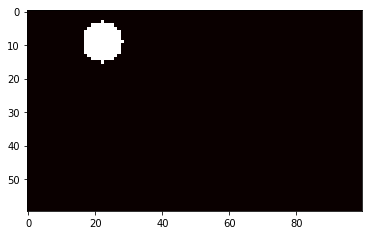



time: 1498671147 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


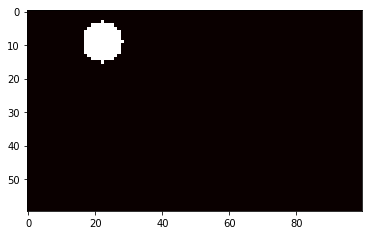



time: 1498671150 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


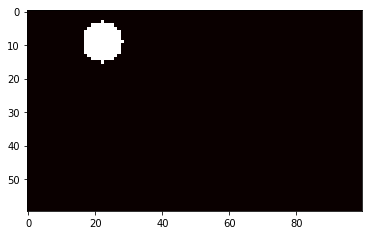



time: 1498671153 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


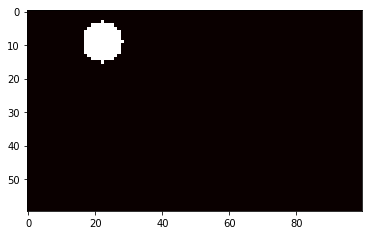



time: 1498671156 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


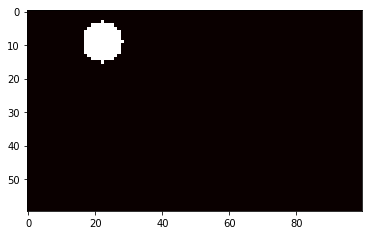



time: 1498671171 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


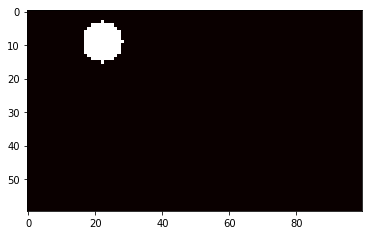



time: 1498671182 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


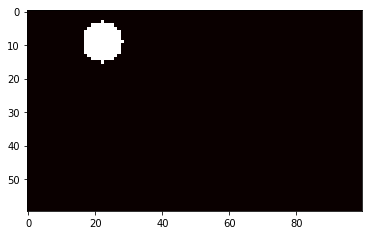



time: 1498671183 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


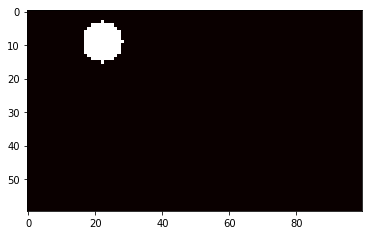



time: 1498671184 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


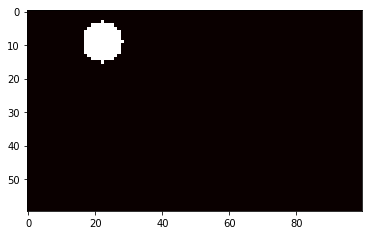



time: 1498671185 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


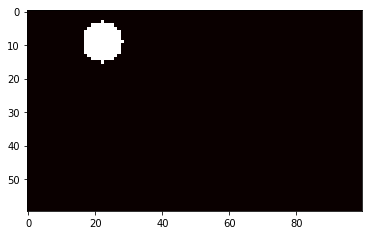



time: 1498671186 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


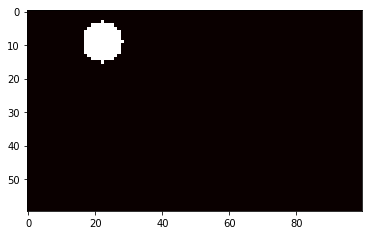



time: 1498671187 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


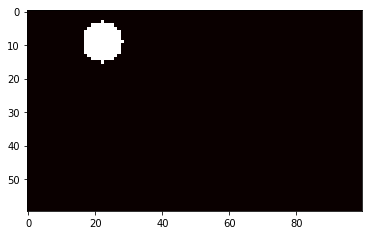



time: 1498671188 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


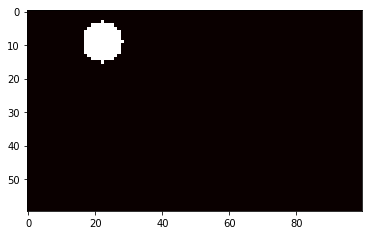



time: 1498671189 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


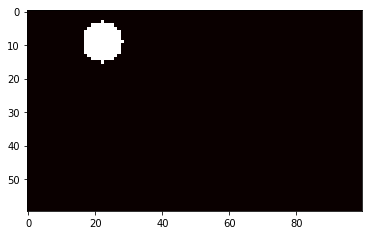



time: 1498671190 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


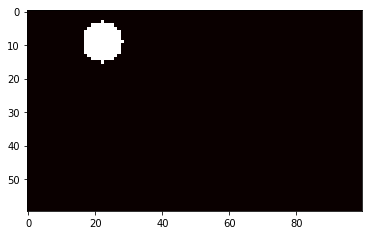



time: 1498671207 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


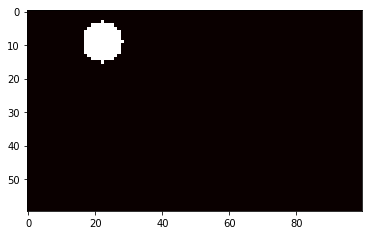



time: 1498671222 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


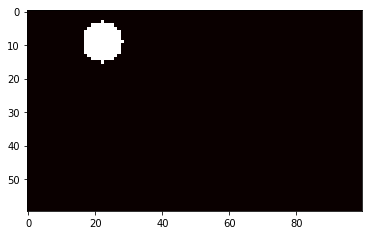



time: 1498671224 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


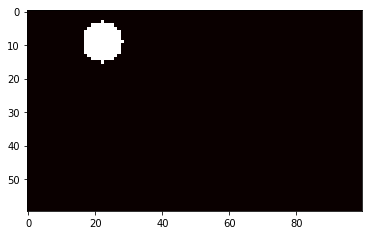



time: 1498671225 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


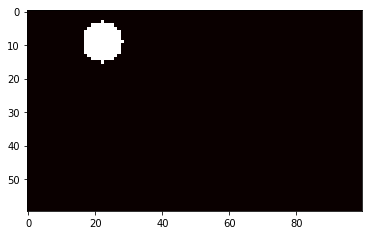



time: 1498671226 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


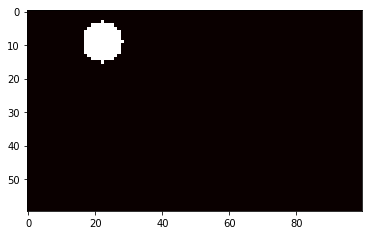



time: 1498671227 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


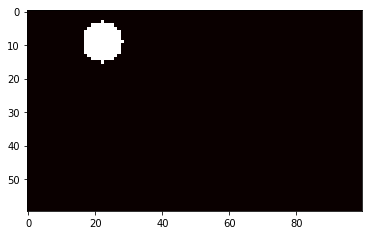



time: 1498671228 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


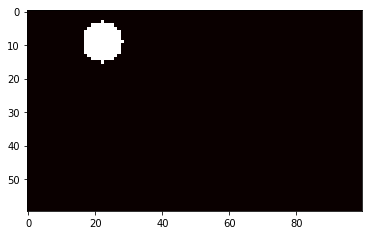



time: 1498671229 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


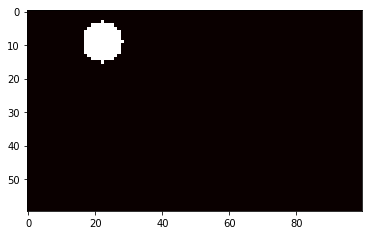



time: 1498671230 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


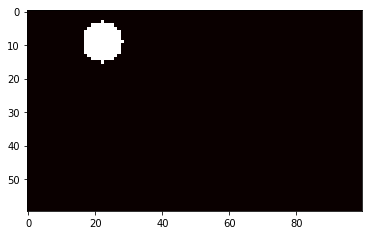



time: 1498671231 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


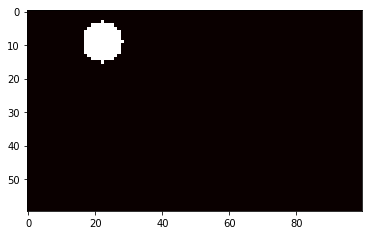



time: 1498671234 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


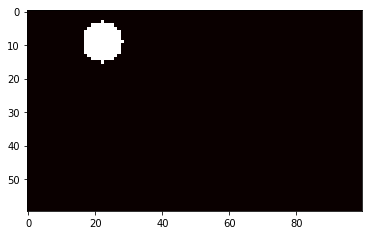



time: 1498671246 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


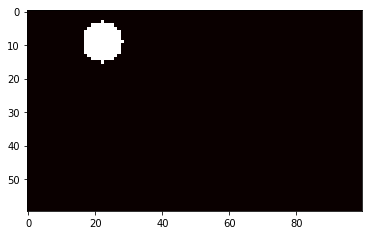



time: 1498671255 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


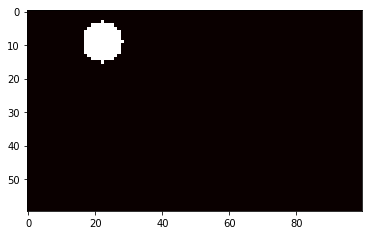



time: 1498671256 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


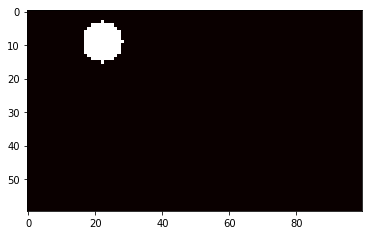



time: 1498671257 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


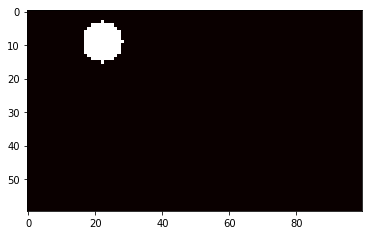



time: 1498671258 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


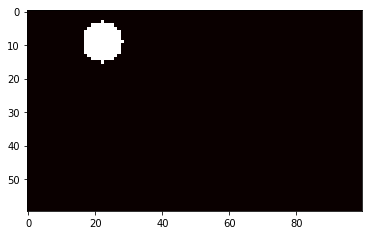



time: 1498671267 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


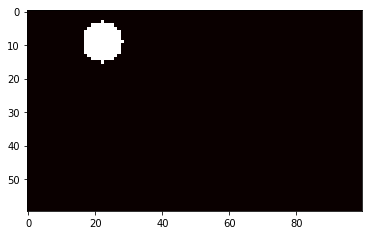



time: 1498671276 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


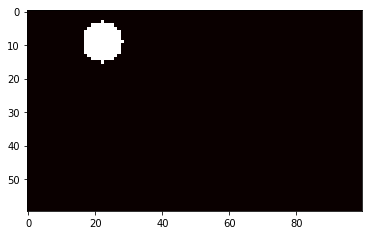



time: 1498671279 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


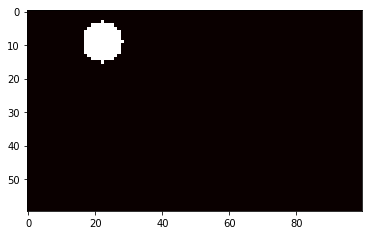



time: 1498671284 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


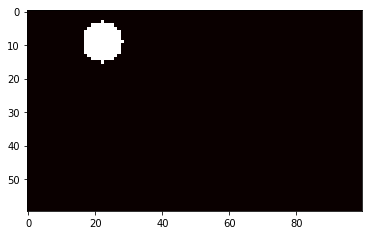



time: 1498671285 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


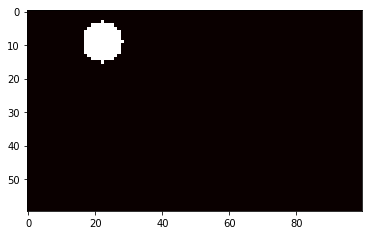



time: 1498671291 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


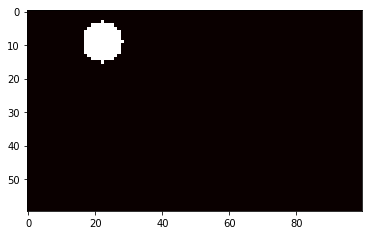



time: 1498671294 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


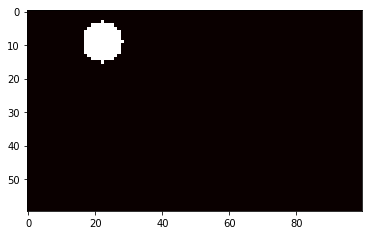



time: 1498671297 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


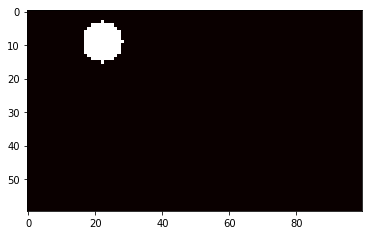



time: 1498671305 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


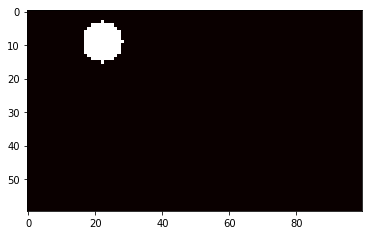



time: 1498671306 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


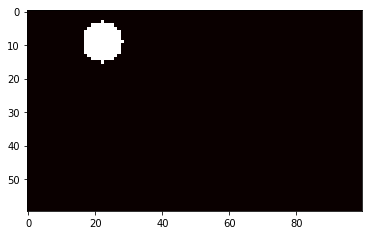



time: 1498671307 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


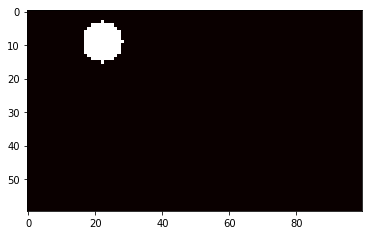



time: 1498671309 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


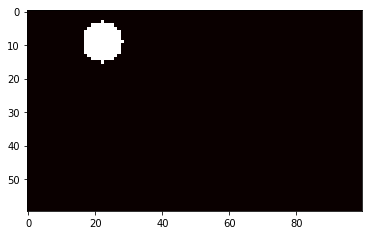



time: 1498671318 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


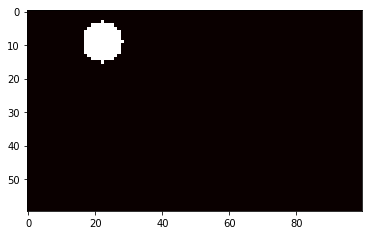



time: 1498671321 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


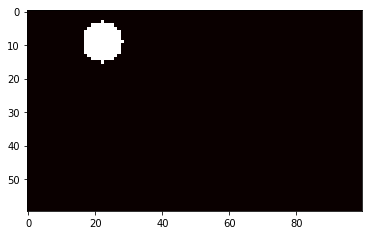



time: 1498671330 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


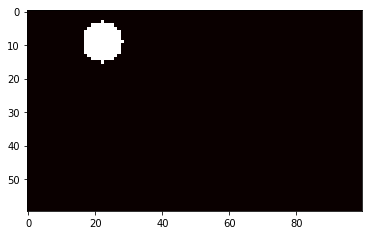



time: 1498671331 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


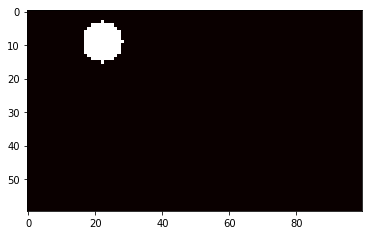



time: 1498671332 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


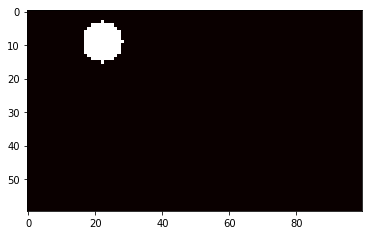



time: 1498671333 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


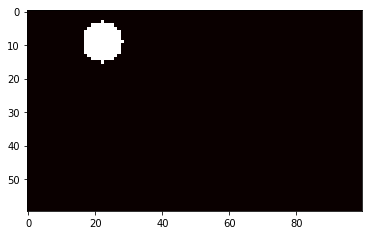



time: 1498671334 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE


KeyboardInterrupt: 

In [31]:
readFileCSV()

In [ ]:
print("please start simulation in casi now.")

In [ ]:
aa = [[0.8, 0], [0, 0]]
print(aa)
# print(*np.where(aa == np.max(aa)))
print(list(zip(*np.where(aa == np.max(aa)))))
np.mean(list(zip(*np.where(aa == np.max(aa)))), axis = 0)